In [6]:
import urllib.request
import ssl
import certifi
import gzip
import shutil
import os
import pandas as pd
import numpy as np
from io import StringIO
from scipy.stats import ttest_ind, zscore
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# 1. Download dataset with SSL context
url = "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE7nnn/GSE7305/matrix/GSE7305_series_matrix.txt.gz"
output_gz = "GSE7305_series_matrix.txt.gz"
output_txt = "GSE7305_series_matrix.txt"

ssl_context = ssl.create_default_context(cafile=certifi.where())

print("Downloading dataset...")
with urllib.request.urlopen(url, context=ssl_context) as response, open(output_gz, 'wb') as out_file:
    shutil.copyfileobj(response, out_file)
print("Download complete!")

# 2. Extract gzip file
print("Extracting the file...")
with gzip.open(output_gz, 'rb') as f_in, open(output_txt, 'wb') as f_out:
    shutil.copyfileobj(f_in, f_out)
print(f"Extracted file saved as {output_txt}")

os.remove(output_gz)
print(f"Deleted compressed file {output_gz}")

Download complete!
Extracting the file...
Extracted file saved as GSE7305_series_matrix.txt
Deleted compressed file GSE7305_series_matrix.txt.gz


In [7]:
# 3. Load expression data, skipping metadata lines starting with '!'
expression_df = pd.read_csv(output_txt, sep="\t", comment='!', index_col=0)
print(f"Initial expression data shape: {expression_df.shape}")

# 4. Clean expression data:
# - Keep only numeric columns (samples)
expression_df = expression_df.select_dtypes(include=[np.number])

# - Remove samples (columns) with >20% missing values
threshold = 0.2
sample_missing_fraction = expression_df.isnull().mean()
samples_to_keep = sample_missing_fraction[sample_missing_fraction <= threshold].index
expression_df = expression_df[samples_to_keep]

# - Remove genes (rows) with >20% missing values
gene_missing_fraction = expression_df.isnull().mean(axis=1)
genes_to_keep = gene_missing_fraction[gene_missing_fraction <= threshold].index
expression_df = expression_df.loc[genes_to_keep]

# - Impute remaining missing values with median per gene
expression_df = expression_df.apply(lambda x: x.fillna(x.median()), axis=1)

# - Remove low variance genes (variance < 0.01)
low_variance_genes = expression_df.var(axis=1) < 0.01
expression_df = expression_df.loc[~low_variance_genes]

# - Log2 transform if needed (if max > 1000)
if expression_df.max().max() > 1000:
    expression_df = np.log2(expression_df + 1)

print(f"Cleaned expression data shape: {expression_df.shape}")


Initial expression data shape: (54675, 20)
Cleaned expression data shape: (54675, 20)


In [8]:
# 5. Load metadata
with open(output_txt, "r") as file:
    lines = file.readlines()

metadata_lines = [line.strip() for line in lines if line.startswith('!Sample_')]
metadata_dict = {}
for line in metadata_lines:
    parts = line.split('\t')
    key = parts[0]
    values = parts[1:]
    metadata_dict[key] = values

# The first metadata line values are sample IDs
sample_ids = list(metadata_dict.values())[0]
meta_df = pd.DataFrame(metadata_dict, index=sample_ids)

# Strip quotes
meta_df = meta_df.applymap(lambda x: x.strip('"') if isinstance(x, str) else x)

# Set sample accession as index
meta_df.set_index('!Sample_geo_accession', inplace=True)

# Create label based on sample titles
meta_df['label'] = meta_df['!Sample_title'].apply(lambda x: 'disease' if 'Disease' in x else ('normal' if 'Normal' in x else 'unknown'))

print(meta_df['label'].value_counts())

label
disease    10
normal     10
Name: count, dtype: int64


/var/folders/h9/qgsr_yv10wl4r1rt1jy83pd00000gn/T/ipykernel_57303/2963802608.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  meta_df = meta_df.applymap(lambda x: x.strip('"') if isinstance(x, str) else x)


In [9]:
# 6. Align samples between expression data and metadata
common_samples = expression_df.columns.intersection(meta_df.index)
expression_df = expression_df[common_samples]
meta_df = meta_df.loc[common_samples]

In [10]:
# 7. Differential expression analysis
disease_samples = meta_df[meta_df['label'] == 'disease'].index
normal_samples = meta_df[meta_df['label'] == 'normal'].index

expr_disease = expression_df[disease_samples]
expr_normal = expression_df[normal_samples]

t_stats, p_vals = ttest_ind(expr_disease.values, expr_normal.values, axis=1, equal_var=False)

_, p_adj, _, _ = multipletests(p_vals, method='fdr_bh')

mean_disease = expr_disease.mean(axis=1)
mean_normal = expr_normal.mean(axis=1)
log2FC = np.log2(mean_disease + 1e-8) - np.log2(mean_normal + 1e-8)

results = pd.DataFrame({
    't_stat': t_stats,
    'p_value': p_vals,
    'p_adj': p_adj,
    'mean_disease': mean_disease,
    'mean_normal': mean_normal,
    'log2FC': log2FC
}, index=expression_df.index)

significant_genes = results[(results['p_adj'] < 0.05) & (results['log2FC'].abs() > 1)]

print(f"Number of significant genes: {significant_genes.shape[0]}")
print(significant_genes.head())

Number of significant genes: 11
                t_stat       p_value         p_adj  mean_disease  mean_normal  \
ID_REF                                                                          
202992_at    42.501328  1.740877e-19  4.759122e-15     11.571295     5.300986   
204591_at    22.546134  1.177158e-13  3.387427e-10      9.074598     4.384400   
205979_at    -8.863485  2.314896e-07  1.142790e-05      5.521439    11.244897   
209560_s_at  24.943227  4.523526e-10  1.359178e-07     10.629070     4.696878   
210002_at    26.727537  2.652606e-15  1.450312e-11      9.254935     4.376740   

               log2FC  
ID_REF                 
202992_at    1.126218  
204591_at    1.049454  
205979_at   -1.026154  
209560_s_at  1.178241  
210002_at    1.080366  


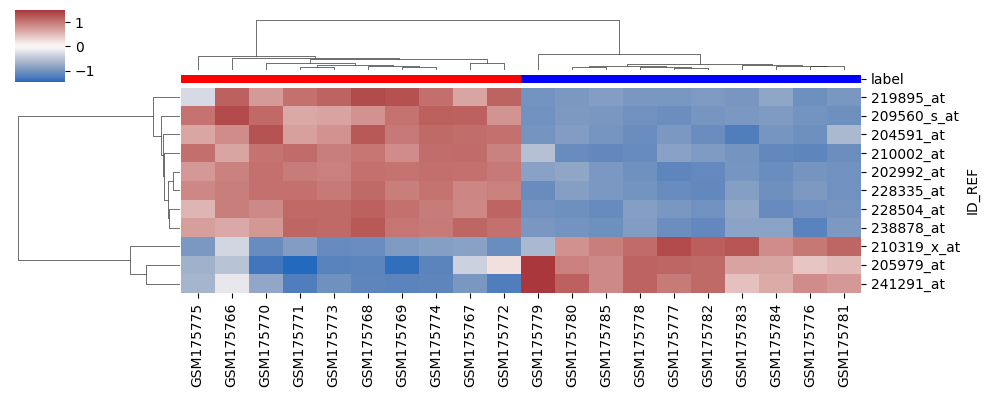

In [11]:
# 8. Heatmap of significant genes (Z-score normalized)
expr_sig = expression_df.loc[significant_genes.index]

expr_z = expr_sig.T.apply(zscore, axis=0).T
sample_colors = meta_df['label'].map({'disease': 'red', 'normal': 'blue'})

sns.clustermap(expr_z, col_colors=sample_colors, cmap='vlag', figsize=(10, max(4, len(expr_z)*0.3)))
plt.show()


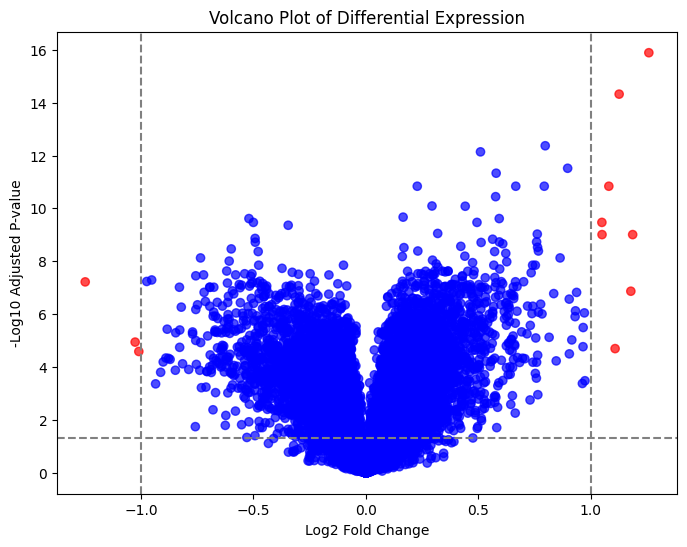

In [12]:
# 9. Volcano plot
plt.figure(figsize=(8,6))
plt.scatter(results['log2FC'], -np.log10(results['p_adj']),
            c=(results['p_adj'] < 0.05) & (results['log2FC'].abs() > 1),
            cmap='bwr', alpha=0.7)
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 Adjusted P-value')
plt.title('Volcano Plot of Differential Expression')
plt.axhline(-np.log10(0.05), color='grey', linestyle='--')
plt.axvline(1, color='grey', linestyle='--')
plt.axvline(-1, color='grey', linestyle='--')
plt.show()

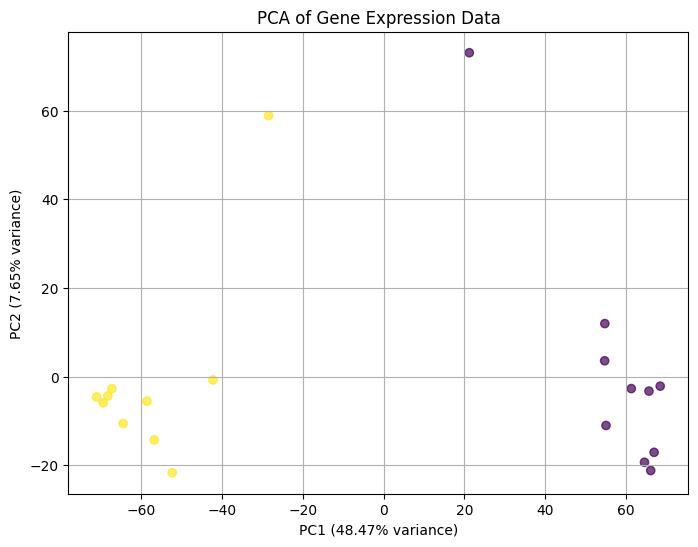

In [14]:
# 10. PCA visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(expression_df.T)
explained_var = pca.explained_variance_ratio_

plt.figure(figsize=(8,6))
plt.scatter(pca_result[:,0], pca_result[:,1], c=sample_colors.map({'red':0, 'blue':1}), alpha=0.7)
plt.xlabel(f'PC1 ({explained_var[0]*100:.2f}% variance)')
plt.ylabel(f'PC2 ({explained_var[1]*100:.2f}% variance)')
plt.title('PCA of Gene Expression Data')
plt.grid(True)
plt.show()

NaNs in expression_df: 0
Infinite values in expression_df: 0
Shape after cleaning: (54675, 20)


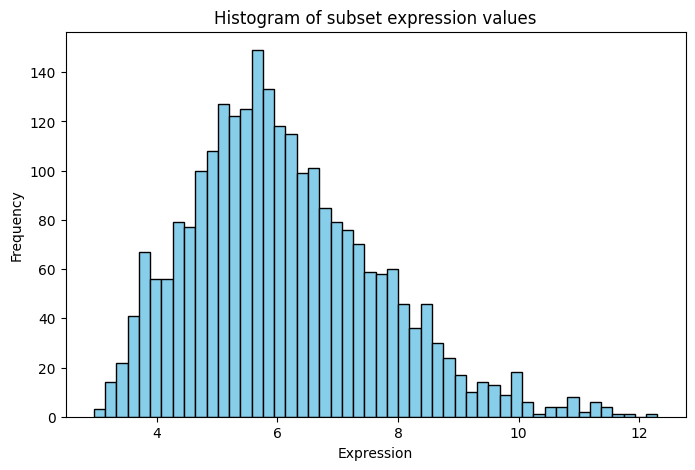

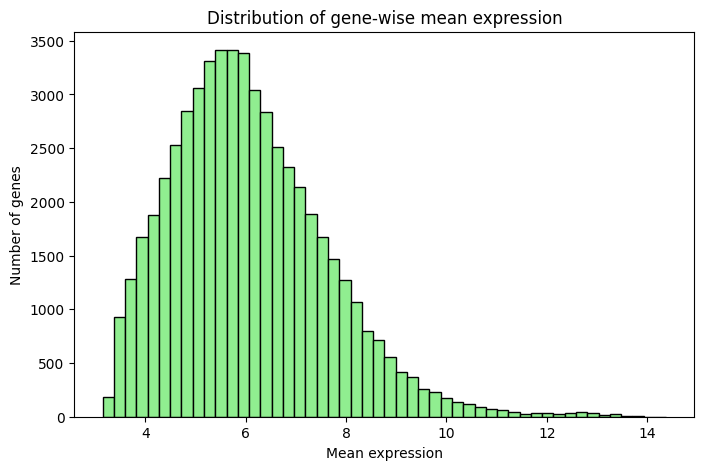

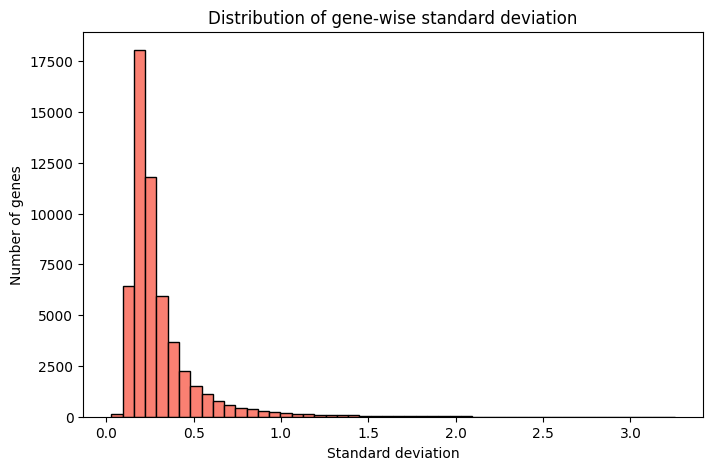

In [18]:
# 11. QC Checks and Distribution Plots

# Check for NaNs or infinite values
print("NaNs in expression_df:", np.isnan(expression_df.values).sum())
print("Infinite values in expression_df:", np.isinf(expression_df.values).sum())

# Clean the data by replacing inf and dropping NaNs
clean_df = expression_df.replace([np.inf, -np.inf], np.nan).dropna(how='any')
print(f"Shape after cleaning: {clean_df.shape}")

# Sample subset for plotting (e.g. 500 genes x 5 samples)
subset = clean_df.sample(n=500, axis=0).sample(n=5, axis=1)

# Flatten subset values for distribution plot
flat_data = subset.values.flatten()

# Plot 1: Histogram of subset expression values
plt.figure(figsize=(8,5))
plt.hist(flat_data, bins=50, color='skyblue', edgecolor='black')
plt.title("Histogram of subset expression values")
plt.xlabel("Expression")
plt.ylabel("Frequency")
plt.show()

# Plot 2: Distribution of gene-wise mean expression across samples
gene_means = clean_df.mean(axis=1)
plt.figure(figsize=(8,5))
plt.hist(gene_means, bins=50, color='lightgreen', edgecolor='black')
plt.title("Distribution of gene-wise mean expression")
plt.xlabel("Mean expression")
plt.ylabel("Number of genes")
plt.show()

# Plot 3: Distribution of gene-wise standard deviation across samples
gene_stds = clean_df.std(axis=1)
plt.figure(figsize=(8,5))
plt.hist(gene_stds, bins=50, color='salmon', edgecolor='black')
plt.title("Distribution of gene-wise standard deviation")
plt.xlabel("Standard deviation")
plt.ylabel("Number of genes")
plt.show()